# Overview 
This documents contains the results of the Routing by spontaneous synchrinization 
paper https://arxiv.org/abs/2305.13914 in a reproducible format


# Simulating and analyzing the EHE system
The following code block contains a high performant (numba accelerated) implementation of the generalized EHE system with a given coupling matrix. 
it returns the sizes, times and participating units of each generated avalanche as well as the current state of potentials u at the end of the simulation (allows to continue the simulation) and the sequence of externally driven units.


In [104]:
import itertools 
import numba
import pickle

@numba.njit(cache=True)
def simulate_model(N,W,p,deltaU,num_steps=None,num_av=None,u0=None):
    u = np.random.random((N,)) if u0 is None else u0
    avc = 0
    step = 0
    neurons = np.arange(N)
    IW = np.eye(N)-W
    avs = []
    avt = []
    pc = np.cumsum(p)
    avu = []
    ks = []
    while avc < num_a  if num_av is not None else step < num_steps:
        k = np.searchsorted(pc,np.random.random())
        ks.append(k)
        u[k] += deltaU
        if u[k] > 1:
            avc+= 1
            avsize = 0
            A = u > 1;
            avinc = np.sum(A)
            avt.append(step)
            avunits = []
            while avinc > 0:
                avsize += avinc
                avunits.extend(np.where(A)[0])
                u = u-IW@A.astype(np.float64)
                A = u>1
                avinc = np.sum(A)
            avs.append(avsize)
            avu.append(avunits)
        step += 1

    return np.array(avs),np.array(avt),avu,u,ks


The following code block implements the analytical avalanche size distribution of a homogeneous ehe system (constant matrix with row sums of alpha) of size N
https://arxiv.org/pdf/2202.02520.pdf (page 74)

In [105]:
import mpmath as mpm 
import numpy as np
def ehe_ana(alpha,N):
    ava = [mpm.exp(mpm.log((1/N))+mpm.log(mpm.binomial(N,n))+mpm.log(n*alpha/N)*(n-1)+
                       mpm.log(1-(n*alpha/N))*(N-n-1)+mpm.log(((1-alpha)/(1-((N-1)/N)*alpha))))
            for n in range(1,N+1)]
    if alpha==0:
        ava[0] = 1
    return ava


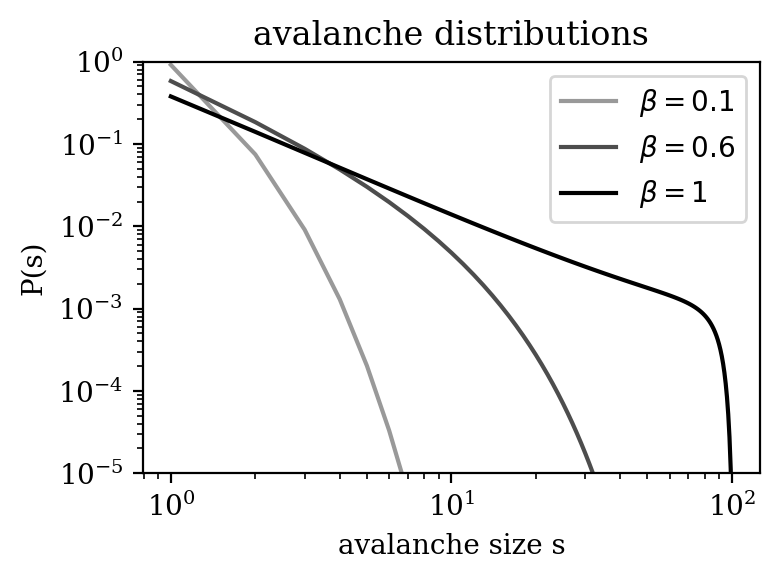

In [106]:
import matplotlib.pyplot as plt
n = 100
plt.figure(figsize=(4,3),dpi=200)
for alpha,c in zip([0.1,0.6,1],[[0.6,0.6,0.6],[0.3,0.3,0.3],[0,0,0]]):
    plt.loglog(np.arange(n)+1,ehe_ana(alpha*0.9,100),label=r'$\beta='+str(alpha)+'$',color=c)
plt.legend()
plt.ylim([1e-5,1])
plt.xlabel('avalanche size s')
plt.ylabel('P(s)')
plt.title('avalanche distributions')
plt.tight_layout()
#plt.savefig('new_example_avs_dists.png',dpi=200)
#plt.savefig('new_example_avs_dists.svg',dpi=200)


# Reproduce V1 population raster plots (Figures 1 and 2)
The next cell uses the simulate_model function to sample activity of the V1 populations A (att=True) and B (att=False) in dependence of the recurrent coupling strength $\beta$ (called $\alpha$ or $c1$ in the code) times the critical coupling strength. The strength of external input is adjusted so that for all values of $\beta$, the population will have a mean firing rate of 40Hz without attention and due to input from the control population 52Hz with att=True. Note that in contrast to the full model, the populations here are driven with an external input of constant rate, without applied flicker

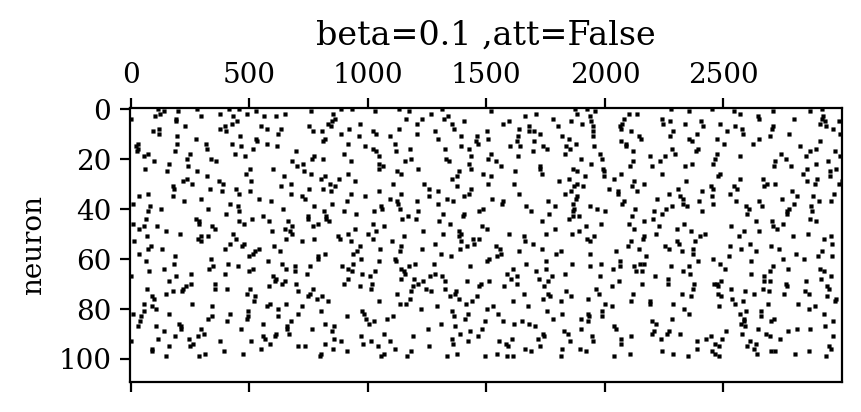

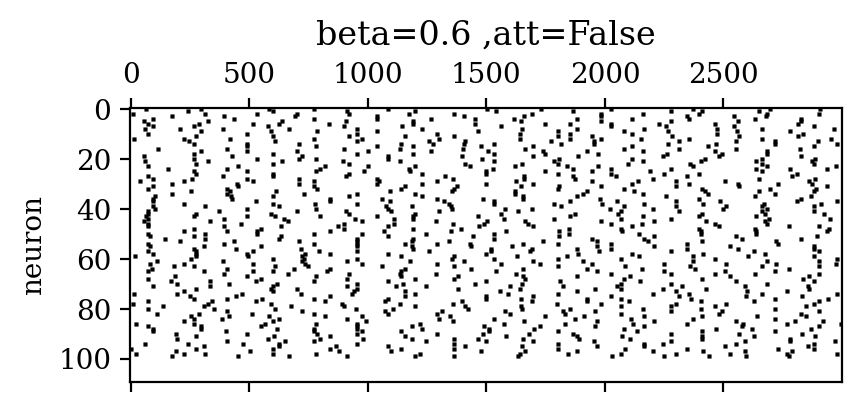

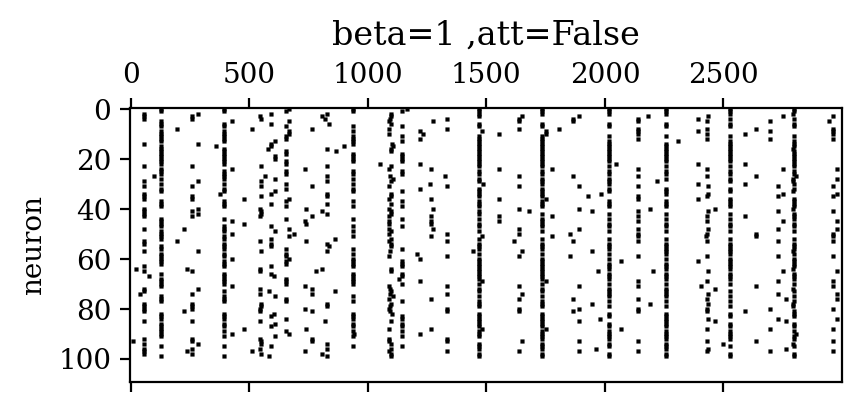

In [107]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib qt
n = 100
att = False
for c1 in [0.1,0.6,1]:#,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    rate1=40;
    ac = 1-1/np.sqrt(n)

    n2 = 10#int(n/10)
    N = n+n2
    W = np.zeros((N,N))
    W[:n,:n] = c1*ac/n
    W[n:N,n:N] = (1-np.sqrt(n2)/n2)/n2
    W[:n,n:N] = 0.095/n2 if att else 0

    dt = 1e-4
    deltaU  = n*(1-c1*ac)*rate1*dt

    p = np.ones(N)/N
    num_steps = 22000
    avs,avt,avu,u,ks = simulate_model(N,W,p,deltaU,num_steps=num_steps)

    offset = 17000
    raster = np.zeros((N,3000))
    raster2 = np.zeros((N,3000))

    pop_act = np.zeros(num_steps)

    for i,u in zip(avt,avu):
        pop_act[i] = len(u)
        if 0 <= i-offset < 3000:
            if np.max(u)>=100:
                raster2[u,i-offset] = 1
            else:
                raster[u,i-offset] = 1

    plt.figure(figsize=[4.59, 4],dpi=200)
    ax1 = plt.subplot(2,1,1)
    plt.spy(raster[:N,:],aspect='auto',markersize=0.5,color='k')
    if att:
        plt.spy(raster2[:N,:],aspect='auto',markersize=0.5,color='red')
        plt.hlines([100],xmin=0,xmax=3000,color='k',linewidth=0.5)
    plt.ylabel('neuron')
    plt.title('beta='+str(c1)+' ,att='+str(att))

# Correlation analysis of full model 


## Numerical simulation results
The main simulation script is found in scripts/ehe_flicker_sync_new_c3_thresh5.py
It simulates the model with a more optimized function that takes into account 
the block structure of the coupling matrix, for a duration of 250 seconds. 
It takes in a task_id and applies the corresponding parameters in param_array:

```
param_array = [(c1,radv,method,trial)
               for c1 in np.linspace(0.2,1,80)
               for radv in [12]
               for method in ['int','ext']
               for trial in range(15)]
```

c1 is the parameter $\beta$ and the published model uses the 'int' method.

This script is submitted to our cluster (sun grid engine) by calling scripts/sge_run.sh with the following
parameters:

```
./sge_run.sh ehe_flicker_sync_new_c3_thresh5 long,granat,maximus 1-2400  cluster/ehe_flicker_sync_new_c3_thresh5.py
```

These simulations took about a week to execute on our cluster. 
The script scripts/sim_Iaf_collect.py collects the individual outputs
of each job into a single npz file with multi-dimensional arrays with 
shape determined by the parameters in param_array.
Running this script then results in the file 

data/sc_collected_ehe_flicker_sync_new_c3_thresh5.npz


Calculation of wavelet spectra as well as spectral coherences were performed using the methods in utils/spectral.py 
## Analytical computation of correlation coefficients and mututal information values


First, we need to compute the avalanche distributions analytically for the whole model. 
This is separated in two steps: First, we condition on the event that a non-empty avalanche occurs and 
use the simplified equations in Appendix, section H.2 for block structured coupling matrices. 


In [108]:
from tqdm import tqdm
import itertools
from itertools import chain, combinations
import sympy as sym
from scipy.special import binom


def vnonin_mod(ns,Us,W,det_func=np.linalg.det):
    Usz_i = np.where(Us==0)[0]
    if len(Usz_i) > 0:
        if np.sum(ns[Usz_i])>0:
            return 0
        Usz_i2 = np.where(Us>0)[0]
        W = W[np.ix_(Usz_i2,Usz_i2)]
        ns = ns[Usz_i2]
        Us = Us[Usz_i2]

    ret = det_func(np.diag(Us)-W@np.diag(ns))*(Us**(ns-1)).prod()
    return ret if not(np.isnan(ret)) else 0



class ModularAvalancheSizeDistributionFast():
    def __init__(self,Ns,W,deltaU=0.022,symbolic=False):
        self.Ns = np.array(Ns)
        self.N = np.sum(Ns)
        self.W = np.array(W)
        self.deltaU = deltaU
        self.volumes = {}
        self.detailed_volumes = {}
        self.probs = {}
        self.det_func = np.linalg.det \
                        if not symbolic else lambda a: sym.Matrix(a).det()


    def detailed_volume(self,st,ns):
        vol = self.detailed_volumes.get((st,tuple(ns)))
        if vol is not None:
            return vol
        num_ass = np.prod([binom(Nsi,nsi) for (Nsi,nsi) in zip(self.Ns,ns)])
        if (ns[st] == 0) or (num_ass==0):
           self.detailed_volumes[(st,tuple(ns))] = 0
           return 0
        ns = np.array(ns)

        vol_is = self.deltaU
        Us = self.W@ns
        vol = 1
        if np.sum(ns)>1 and ns[st]>0:
            remu = ns.copy()
            remu[st]-=1
            vol = ns[st]*vnonin_mod(remu,Us,self.W,det_func=self.det_func)
        if vol == 0:
            self.detailed_volumes[(st,tuple(ns))] = vol
            return vol
        volc = 1
        if (ns <= self.Ns).all() and np.sum(ns)<np.sum(self.Ns):
            Ucs = 1-Us
            ncs = self.Ns-ns
            volc = vnonin_mod(ncs,Ucs,self.W,det_func=self.det_func)
        # debug print    
        #print('num_ass,vol_is vol volc',num_ass,vol_is,vol,volc)
        vol = num_ass*vol_is*vol*volc
        self.detailed_volumes[(st,tuple(ns))] = vol
        return vol

    def volume_size0_st(self,st):
        vol = 0
        remu = self.Ns.copy()
        remu[st]-=1
        vol = self.Ns[st]*self.deltaU*vnonin_mod(remu,np.ones(self.W.shape[0]),self.W,det_func=self.det_func)
        return vol

    def volume_size0(self):
        return np.sum([self.volume_size0_st(i) for i in range(self.W.shape[0])])

    def volume(self,n):
        vol = self.volumes.get(n)
        if vol is not None:
            return vol
        #print("n",n)    
        if n == 0:
            vol = self.volume_size0()
            self.volumes[n] = vol
            return vol
        vol = 0
        # iterate over all possible assignments
        for ns in itertools.product(*[list(range(min(Nsi+1,n+1))) for Nsi in self.Ns]):
            if np.sum(ns)==n:
                for st in range(self.W.shape[0]):
                    vol += self.detailed_volume(st,ns)
        self.volumes[n] = vol
        return vol

    def compute_all(self):
        self.volumes = {i:0 for i in range(np.sum(self.Ns)+1)};
        self.volumes[0] = self.volume_size0()
        asses = list(itertools.product(*[range(Nsi+1) for Nsi in self.Ns]))
        for ns in tqdm(asses):
            if np.sum(ns)>0:                 
                vol = 0
                for st in range(self.W.shape[0]):
                        #print("vol ",self.detailed_volume(st,ns))
                        vol += self.detailed_volume(st,ns)
                self.volumes[np.sum(ns)]+=vol

    def prob(self,n):
        prob = self.probs.get(n)
        if prob is not None:
            return prob
        norm_n = self.volume(n)
        norm_0 = self.volume(0)
        prob = norm_n/norm_0
        self.probs[n] = prob
        return prob

    def avs_dist(self):
        for i in range(1,self.N+1):
            self.prob(i)
        return self.probs    

We use the class ModularAvalancheSizeDistributionFast to compute the avalanche
distributions in all subnetworks in the function detailed_avs_dist_3pop

In [109]:
def detailed_avs_dist_3pop(c1,c3='auto',cup=0.3,c_control=0.095,n=100,deltaU=1,return_vol=False):
    n2 = int(n/10)
    Ns = (n,n,n2,n)
    ac = 1-1/np.sqrt(n)
    c2 = c1
    if c3=='auto':
        c3 = c2-2*cup
        assert(c3>0)
    Ws = np.zeros((4,4))#one extra unit to supply the overshoot of deltaU external inputs
    Ws[0,0] = c1*ac/n # V1 A
    # Ws[1,:] is inhibited second population of nonattended V1
    Ws[1,1] = c2*ac/n # V1 B 
    Ws[2,2] = (1-np.sqrt(n2)/n2)/n2
    Ws[1,2] = c_control/n2 # input from crit subnet to V1 B # 0.03 für n=1000
    Ws[3,3] = c3*ac/n # V4 pop
    Ws[3,0] = cup/n # inputs to V4
    Ws[3,1] = cup/n
    avsd = ModularAvalancheSizeDistributionFast(Ns,Ws,deltaU=1)
    p = np.ones(len(Ns))#/len(Ns)
    v_V1aV4 = np.array([[avsd.detailed_volume(0,(i,0,0,j)) for j in range(0,n+1)] for i in range(n+1)])
    p_V1aV4 = p[0]*avsd.volume_size0_st(0)
    v_V1bV4 = np.array([[avsd.detailed_volume(1,(0,i,0,j)) for j in range(0,n+1)] for i in range(n+1)])
    p_V1bV4 = p[1]*avsd.volume_size0_st(1)
    v_V1bcV4 = np.array([[[avsd.detailed_volume(2,(0,j,i,k)) for k in range(0,n+1)]
                          for j in range(0,n+1)] for i in range(n2+1)])
    p_V1bcV4 = p[2]*avsd.volume_size0_st(2)
    v_V4 = np.array([avsd.detailed_volume(3,(0,0,0,i)) for i in range(0,n+1)])
    p_V4 = p[3]*avsd.volume_size0_st(3)
    # explanation: v_... is the unnormalized distribution
    # the corresponding p_... is the probability of a non-empty avalanche
    # therefore, the fraction of v and p give the avalanche size distribution
    # only the p parameters depend on the input statistics!
    if return_vol:
        vol = vnonin_mod(np.array(Ns),np.ones_like(Ns),Ws)
        return ((v_V1aV4, p_V1aV4, v_V1bV4, p_V1bV4, v_V1bcV4, p_V1bcV4, v_V4, p_V4),vol)
    return (v_V1aV4, p_V1aV4, v_V1bV4, p_V1bV4, v_V1bcV4, p_V1bcV4, v_V4, p_V4)

def avs_size_distributions_3pop(detailed_dist,s,V4ext=False,p = None,n=100):
    v_V1aV4, p_V1aV4, v_V1bV4, p_V1bV4, v_V1bcV4, p_V1bcV4, v_V4, p_V4 = detailed_dist
    n2 = int(n/10)
    p = np.ones(4)/4 if p is None else p
    p_w = p*np.array([n,n,n2,n])/(3*n+n2)
    # Question: Does p need to sum to 1 how to handle n2 and n parts analytically?
    V1a = p_w[0]*np.array([np.sum(v_V1aV4[i,:]) for i in np.arange(n)+1])/(p_V1aV4*p_w[0])
    #TODO Hier weitermachen!!!
    V1b = (p_w[2]*np.array([np.sum(v_V1bcV4[:,i,:]) for i in np.arange(n)+1])/(p_V1bcV4-np.sum(v_V1bcV4[:,0,:]))
           +p_w[1]*np.array([np.sum(v_V1bV4[i,:]) for i in np.arange(n)+1])/p_V1bV4)/(p_w[1]+p_w[2])
    V4 = ((p_w[3]*v_V4[1:]/p_V4 if V4ext else 0)+
          p_w[0]*np.array([np.sum(v_V1aV4[s:,i]) for i in np.arange(n)+1])/
          (p_V1aV4-np.sum(v_V1aV4[:,0])-np.sum(v_V1aV4[:s,1:]))+
          p_w[1]*np.array([np.sum(v_V1bV4[s:,i]) for i in np.arange(n)+1])/
          (p_V1bV4-np.sum(v_V1bV4[:,0])-np.sum(v_V1bV4[:s,1:]))+
          p_w[2]*np.array([np.sum(v_V1bcV4[:,s:,i]) for i in np.arange(n)+1])/
          (p_V1bcV4-np.sum(v_V1bcV4[:,:,0])-np.sum(v_V1bcV4[:,:s,1:])))/(p_w[0]+p_w[1]+p_w[2]+(p_w[3] if V4ext else 0))
    return V1a,V1b,V4



First, we precompute the individual avalanche distributions. 
Umcomment c1_idxs, and the last line in order to recreate the file
data/dist_vols_n100.pickle

In [110]:
import pickle
xs = np.linspace(-1,1,5)
ys = np.linspace(-1,1,5)
zs = np.arange(101)
MI_fA4s = []
MI_fB4s = []
corr_fA4s = []
corr_fB4s = []
c1_idxs = []#np.arange(80)
for c1_idx in c1_idxs:
    c1 = np.linspace(0.2,1,80)[c1_idx]
    print('c1',c1)
    c3 = 0.4#'auto'
    cup=0.3;
    c_control = 0.095
    n=100;
    n2 = 10
    c=0.25
    dt=1e-6
    rate1=40
    ac = 1-1/np.sqrt(n)
    ra1 = 1/(n-n*ac*c1) # rate ana 1 step
    norm = ((2*n+n2)*(1+c))
    deltaU = dt*n*rate1/(ra1*norm)

    import time
    st = time.time()
    dist_vol = detailed_avs_dist_3pop(c1,c3,cup,c_control,n,return_vol=True)
    print(time.time()-st)
    dist_vols.append(dist_vol)

#pickle.dump(dist_vols,open('data/dist_vols_n=100.pickle','wb'))



### Analytical correlation and MI for flicker to V1
Now we are ready to construct the joint probability mass function (pmf) for the 
flicker and V1 population activity and use it to compute correlations and MI values.

Note that in the computer code, always V1 node B is on the attended pathway, 
so you need to exchange A<->B when comparing with the model equations in the paper

In [ ]:
xs = np.linspace(-1,1,5)
ys = np.linspace(-1,1,5)
zs = np.arange(101)
MI_fAAs = []
MI_fBBs = []
corr_fAAs = []
corr_fBBs = []
bcorr_fAAs = []
bcorr_fBBs = []
thresholds = [5]
c1_idxs = np.arange(80)
c1_idxs = [] # COMMENT THIS LINE TO RECALCULATE
dist_vols = pickle.load(open('data/dist_vols_n=100.pickle','rb'))
for c1_idx in c1_idxs:
    MI_fAAs.append([])
    MI_fBBs.append([])
    corr_fAAs.append([])
    corr_fBBs.append([])
    bcorr_fAAs.append([])
    bcorr_fBBs.append([])
    c1 = np.linspace(0.2,1,80)[c1_idx]
    print('c1',c1)
    c3 = 0.4#'auto'
    cup=0.3;
    c_control = 0.095
    n=100;
    n2 = 10
    c=0.25
    dt=1e-6
    rate1=40
    ac = 1-1/np.sqrt(n)
    ra1 = 1/(n-n*ac*c1) # rate ana 1 step
    norm = ((2*n+n2)*(1+c))
    p0 = 0.266666666 # taken from simulation code!
    deltaU = (n*(1-ac*c1))*rate1*dt/p0 # solve for condition V1 has rate1 firing rate
    
    detailed_dist,vol = dist_vols[c1_idx]
    v_V1aV4, p_V1aV4, v_V1bV4, p_V1bV4, v_V1bcV4, p_V1bcV4, v_V4, p_V4 = detailed_dist

    n = 100
    n2 = 10

    #Probability of non-empty avalanche : p*DeltaU*p_Vxxx/vol_hypercube
    # vol_hypercube = vnonin_mod(NS,np.ones_like(Ns),W)

    # NOW: pmf of flicker->V1
    for s in thresholds:
        print('s',s)
        norm = ((2*n+n)*(1+c))
        p_base = np.array([n,n,n,0])/norm
        pmf_a = np.zeros((5,101))
        pmf_b = np.zeros((5,101))
        # TODO s einbauen!!!!!
        #s=10
        for ia,lA in enumerate(xs):
            p = p_base.copy()
            p0 = p[0]*(1+c*lA)
            pmf_a[ia,0] = 1-p0
            pmf_a[ia,0] += p0*(1-deltaU*p_V1aV4/vol/n)
            pmf_a[ia,:] += p0*deltaU*np.sum(v_V1aV4,axis=1)/vol/n
            pmf_b[ia,0] = 1-2*p0
            pmf_b[ia,0] += p0*(1-deltaU*p_V1bV4/vol/n)  
            pmf_b[ia,:] += p0*deltaU*np.sum(v_V1bV4,axis=1)/vol/n 
            pmf_b[ia,0] += p0*(1-deltaU*p_V1bcV4/vol/n)
            pmf_b[ia,:] += p0*deltaU*np.sum(v_V1bcV4,axis=(0,2))/vol/n
        pmf_a = pmf_a/5
        pmf_b = pmf_b/5

        # generate conditional distributions with dit in base2 and then convert to linear numpy arrays!
        import dit
        da = dit.Distribution.from_ndarray(np.log2(pmf_a),base=2)
        db = dit.Distribution.from_ndarray(np.log2(pmf_b),base=2)
        #print(dit.shannon.mutual_information(d,[0],[2]))
        MI_fAAs[-1].append(dit.shannon.mutual_information(da,[0],[1]))
        #print(dit.shannon.mutual_information(d,[1],[2]))
        MI_fBBs[-1].append(dit.shannon.mutual_information(db,[0],[1]))
        # compute correlation coefficient
        d_fAA = da
        d_fBB = db
        d_fA = da.marginal([0])
        d_fB = db.marginal([0])
        d_A = da.marginal([1])
        d_B = db.marginal([1])
        E_fA = 0#np.sum([xs*np.exp2(d_fA[i,]) for i in range(5)])
        E_fB = 0
        E_fA2 = np.sum([x**2*np.exp2(d_fA[i,]) for i,x in enumerate(xs)])
        E_fB2 = np.sum([x**2*np.exp2(d_fB[i,]) for i,x in enumerate(xs)])
        E_1A = np.sum([np.exp2(d_A[i,])*i for i in range(101)])
        E_1B = np.sum([np.exp2(d_B[i,])*i for i in range(101)])
        E_1A2 = np.sum([np.exp2(d_A[i,])*i**2 for i in range(101)])
        E_1B2 = np.sum([np.exp2(d_B[i,])*i**2 for i in range(101)])
        E_fAA = np.sum([np.exp2(d_fAA[i,j])*lA*nV1 for i,lA in enumerate(xs) for j,nV1 in enumerate(range(101))])
        E_fBB = np.sum([np.exp2(d_fBB[i,j])*lB*nV1 for i,lB in enumerate(ys) for j,nV1 in enumerate(range(101))])
        
        corr_fAA = (E_fAA-E_fA*E_1A)/(np.sqrt(E_fA2-E_fA**2)*np.sqrt(E_1A2-E_1A**2))
        corr_fBB = (E_fBB-E_fB*E_1B)/(np.sqrt(E_fB2-E_fB**2)*np.sqrt(E_1B2-E_1B**2))
        corr_fAAs[-1].append(corr_fAA)
        corr_fBBs[-1].append(corr_fBB)
        
        num_binned = 1000
        bvE_1A = (E_1A2-E_1A**2)/num_binned
        bvE_1B = (E_1B2-E_1B**2)/num_binned
        bE_1A2 = E_1A**2+bvE_1A
        bE_1B2 = E_1B**2+bvE_1B
        
        bcorr_fAA = (E_fAA-E_fA*E_1A)/(np.sqrt(E_fA2-E_fA**2)*np.sqrt(bE_1A2-E_1A**2))
        bcorr_fBB = (E_fBB-E_fB*E_1B)/(np.sqrt(E_fB2-E_fB**2)*np.sqrt(bE_1B2-E_1B**2))
        bcorr_fAAs[-1].append(bcorr_fAA)
        bcorr_fBBs[-1].append(bcorr_fBB)



acs = np.array(bcorr_fAAs)
bcs = np.array(bcorr_fBBs)
#pickle.dump([thresholds,np.linspace(0.2,1,80),acs,bcs],open('flicker_v1_corrs_mis_c1_thresholds.pickle','wb'))


### From V1 population activity to V4 population activity
The structure of the code is very similar to the previous cell.

In [ ]:
xs = np.linspace(-1,1,5)
ys = np.linspace(-1,1,5)
zs = np.arange(101)
MI_A4s = []
MI_B4s = []
corr_A4s = []
corr_B4s = []
bcorr_A4s = []
bcorr_B4s = []
thresholds = range(1,21)
thresholds = [5]
c1_idxs = np.arange(80)
c1_idxs = [] # COMMENT THIS LINE TO RECALCULATE
dist_vols = pickle.load(open('data/dist_vols_n=100.pickle','rb'))
for c1_idx in c1_idxs:
    MI_A4s.append([])
    MI_B4s.append([])
    corr_A4s.append([])
    corr_B4s.append([])
    bcorr_A4s.append([])
    bcorr_B4s.append([])
    c1 = np.linspace(0.2,1,80)[c1_idx]
    print('c1',c1)
    c3 = 0.4#'auto'
    cup=0.3;
    c_control = 0.095
    n=100;
    n2 = 10
    c=0.25
    dt=1e-6
    rate1=40
    ac = 1-1/np.sqrt(n)
    ra1 = 1/(n-n*ac*c1) # rate ana 1 step
    norm = ((2*n+n2)*(1+c))
    p0 = 0.266666666 # taken from simulation code!
    deltaU = (n*(1-ac*c1))*rate1*dt/p0 # solve for condition V1 has rate1 firing rate
    detailed_dist,vol = dist_vols[c1_idx]
    v_V1aV4, p_V1aV4, v_V1bV4, p_V1bV4, v_V1bcV4, p_V1bcV4, v_V4, p_V4 = detailed_dist

    n = 100
    n2 = 10

    # AND NOW V1->V4 analytically!!!!!
    for s in thresholds:
        print('s',s)
        norm = ((2*n+n)*(1+c))
        p_base = np.array([n,n,n,0])/norm
        pmf_a = np.zeros((101,101))
        pmf_b = np.zeros((101,101))
        for ia,lA in enumerate(xs):
            for ib,lB in enumerate(ys):
                p = p_base.copy()
                p[0] = p[0]*(1+c*lA)
                p[1:3] = p[1:3]*(1+c*lB)
                pmf_a[0,0] += 1-np.sum(p) # Prob no unit gets selected! 
                pmf_b[0,0] += 1-np.sum(p) # Prob no unit gets selected! 
                # Jetzt über alle Wege im Netzwerk summieren!
                # Weg V1a
                pmf_a[0,0] += p[0]*(1-deltaU*p_V1aV4/vol/n) # no avalanche in V1
                pmf_a[:s,0] += p[0]*deltaU*np.sum(v_V1aV4[:s,:],axis=1)/vol/n
                pmf_a[s:,:] += p[0]*deltaU*v_V1aV4[s:,:]/vol/n
                # kreuzweg 
                pmf_b[0,0] += p[0]*(1-deltaU*p_V1aV4/vol/n)
                pmf_b[0,0] += p[0]*deltaU*np.sum(v_V1aV4[:s,:])/vol/n
                pmf_b[0,:] += p[0]*deltaU*np.sum(v_V1aV4[s:,:],axis=0)/vol/n
                # Weg V1b 
                pmf_b[0,0] += p[1]*(1-deltaU*p_V1bV4/vol/n)  
                pmf_b[:s,0] += p[1]*deltaU*np.sum(v_V1bV4[:s,:],axis=1)/vol/n
                pmf_b[s:,:] += p[1]*deltaU*v_V1bV4[s:,:]/vol/n
                # kreuzweg
                pmf_a[0,0] += p[1]*(1-deltaU*p_V1bV4/vol/n)
                pmf_a[0,0] += p[1]*deltaU*np.sum(v_V1bV4[:s,:])/vol/n
                pmf_a[0,:] += p[1]*deltaU*np.sum(v_V1bV4[s:,:],axis=0)/vol/n
                # Weg control to V1b
                pmf_b[0,0] += p[2]*(1-deltaU*p_V1bcV4/vol/n)  
                pmf_b[:s,0] += p[2]*deltaU*np.sum(v_V1bcV4[:,:s,:],axis=(0,2))/vol/n
                pmf_b[s:,:] += p[2]*deltaU*np.sum(v_V1bcV4[:,s:,:],axis=0)/vol/n
                # kreuzweg
                pmf_a[0,0] += p[2]*(1-deltaU*p_V1bcV4/vol/n)
                pmf_a[0,0] += p[2]*deltaU*np.sum(v_V1bcV4[:,:s,:])/vol/n
                pmf_a[0,:] += p[2]*deltaU*np.sum(v_V1bcV4[:,s:,:],axis=(0,1))/vol/n
        pmf_a = pmf_a/25
        pmf_b = pmf_b/25

        # generate conditional distributions with dit in base2 and then convert to linear numpy arrays!
        import dit
        da = dit.Distribution.from_ndarray(np.log2(pmf_a),base=2)
        db = dit.Distribution.from_ndarray(np.log2(pmf_b),base=2)
        MI_A4s[-1].append(dit.shannon.mutual_information(da,[0],[1]))
        MI_B4s[-1].append(dit.shannon.mutual_information(db,[0],[1]))

        # compute correlation coefficient
        d_A4 = da
        d_B4 = db
        d_A = da.marginal([0])
        d_B = db.marginal([0])
        d_4 = da.marginal([1]) # same as db.marginal([1])
        E_A = np.sum([np.exp2(d_A[i,])*i for i in range(101)])
        E_B = np.sum([np.exp2(d_B[i,])*i for i in range(101)])
        E_A2 = np.sum([np.exp2(d_A[i,])*i**2 for i in range(101)])
        E_B2 = np.sum([np.exp2(d_B[i,])*i**2 for i in range(101)])
        E_4 = np.sum([np.exp2(d_4[i,])*i for i in range(101)])
        E_42 = np.sum([np.exp2(d_4[i,])*i**2 for i in range(101)])
        E_A4 = np.sum([np.exp2(d_A4[i,j])*i*j for i in range(101) for j in range(101)])
        E_B4 = np.sum([np.exp2(d_B4[i,j])*i*j for i in range(101) for j in range(101)])
        
        corr_A4 = (E_A4-E_A*E_4)/(np.sqrt(E_A2-E_A**2)*np.sqrt(E_42-E_4**2))
        corr_B4 = (E_B4-E_B*E_4)/(np.sqrt(E_B2-E_B**2)*np.sqrt(E_42-E_4**2))
      
        corr_A4s[-1].append(corr_A4)
        corr_B4s[-1].append(corr_B4)

        bcorr_A4s[-1].append(corr_A4)
        bcorr_B4s[-1].append(corr_B4)

acs = np.array(bcorr_A4s)
bcs = np.array(bcorr_B4s)
#pickle.dump([thresholds,np.linspace(0.2,1,80),acs,bcs],open('data/v1_v4_corrs_mis_c1_thresholds.pickle','wb'))


### correlation and MI from flicker to V4 activity
all that remains is to calculate the pathway from flicker to V4. 
The structure of the code is again very similar to the other paths.
Computation time is around 40 minutes.

In [61]:
from tqdm import tqdm
xs = np.linspace(-1,1,5)#5)
ys = np.linspace(-1,1,5)#5)
zs = np.arange(101)
MI_fA4s = []
MI_fB4s = []
CIs = []
corr_fA4s = []
corr_fB4s = []
bcorr_fA4s = []
bcorr_fB4s = []
thresholds = range(21) # [5]

c1_idxs = np.arange(80)
c1_idxs = [] # COMMENT THIS LINE TO RECALCULATE
pmfs = np.zeros((5,5,101,100))
#c1_idxs = [55]
dist_vols = pickle.load(open('data/dist_vols_n=100.pickle','rb'))
for c1_idx in tqdm(c1_idxs):
    MI_fA4s.append([])
    MI_fB4s.append([])
    CIs.append([])
    corr_fA4s.append([])
    corr_fB4s.append([])
    bcorr_fA4s.append([])
    bcorr_fB4s.append([])
    c1 = np.linspace(0.2,1,80)[c1_idx]
    #print('c1',c1)
    c3 = 0.4#'auto'
    cup=0.3;
    c_control = 0.095
    n=100;
    n2 = 10
    c=0.25
    dt=1e-6
    rate1=40
    ac = 1-1/np.sqrt(n)
    ra1 = 1/(n-n*ac*c1) # rate ana 1 step
    norm = ((2*n+n2)*(1+c))
    p0 = 0.266666666 # taken from simulation code!
    deltaU = (n*(1-ac*c1))*rate1*dt/p0 # solve for condition V1 has rate1 firing rate
   
    detailed_dist,vol = dist_vols[c1_idx]
    v_V1aV4, p_V1aV4, v_V1bV4, p_V1bV4, v_V1bcV4, p_V1bcV4, v_V4, p_V4 = detailed_dist

    n = 100
    n2 = 10
  
    for s in tqdm(thresholds):
        #print('s',s)
        norm = ((2*n+n)*(1+c))
        p_base = np.array([n,n,n,0])/norm
        pmf = np.zeros((len(xs),len(ys),101))
        for ia,lA in enumerate(xs):
            for ib,lB in enumerate(ys):
                #print(ia,ib)
                p = p_base.copy()
                p[0] = p[0]*(1+c*lA)
                p[1:3] = p[1:3]*(1+c*lB)
                pmf[ia,ib,0] = 1-np.sum(p) # Prob no unit gets selected! TODO
                # Jetzt über alle Wege im Netzwerk summieren!
                # Weg V1a zu V4
                pmf[ia,ib,0] += p[0]*(1-deltaU*(p_V1aV4-np.sum(v_V1aV4[:s,:]))/vol/n)  
                pmf[ia,ib,:] += p[0]*deltaU*np.sum(v_V1aV4[s:,:],axis=0)/vol/n 
                # Weg V1b zu V4
                pmf[ia,ib,0] += p[1]*(1-deltaU*(p_V1bV4-np.sum(v_V1bV4[:s,:]))/vol/n)  
                pmf[ia,ib,:] += p[1]*deltaU*np.sum(v_V1bV4[s:,:],axis=0)/vol/n 
                # Weg V1bc zu V4
                pmf[ia,ib,0] += p[2]*(1-deltaU*(p_V1bcV4-np.sum(v_V1bcV4[:,:s,:]))/vol/n)  
                pmf[ia,ib,:] += p[2]*deltaU*np.sum(v_V1bcV4[:,s:,:],axis=(0,1))/vol/n

                #print('sum pmf',np.sum(pmf[ia,ib,:]))
        pmf = pmf/len(xs)**2
        #spmf = spmf/len(xs)**2
        pmfs[:,:,:,c1_idx] = pmf

        # generate conditional distributions with dit in base2 and then convert to linear numpy arrays!
        import dit
        d = dit.Distribution.from_ndarray(np.log2(pmf),base=2)
        #print(dit.shannon.mutual_information(d,[0],[2]))
        MI_fA4s[-1].append(dit.shannon.mutual_information(d,[0],[2]))
        #print(dit.shannon.mutual_information(d,[1],[2]))
        MI_fB4s[-1].append(dit.shannon.mutual_information(d,[1],[2]))
        #print(dit.shannon.mutual_information(d,[1],[2])/dit.shannon.mutual_information(d,[0],[2]))
        CIs[-1].append(dit.shannon.mutual_information(d,[2],[0,1])-
                       dit.shannon.mutual_information(d,[0],[2])-
                       dit.shannon.mutual_information(d,[1],[2]))
        #print('synergistic_information',CIs[-1][-1])

        # compute correlation coefficient
        d_fA4 = d.marginal([0,2])
        d_fB4 = d.marginal([1,2])
        d_fA = d.marginal([0])
        d_fB = d.marginal([1])
        d_4 = d.marginal([2])
        E_fA = 0#np.sum([xs*np.exp2(d_fA[i,]) for i in range(5)])
        E_fB = 0
        E_fA2 = np.sum([x**2*np.exp2(d_fA[i,]) for i,x in enumerate(xs)])
        E_fB2 = np.sum([x**2*np.exp2(d_fB[i,]) for i,x in enumerate(xs)])
        E_4 = np.sum([np.exp2(d_4[i,])*i for i in range(101)])
        E_42 = np.sum([np.exp2(d_4[i,])*i**2 for i in range(101)])
        E_fA4 = np.sum([np.exp2(d_fA4[i,j])*lA*nV4 for i,lA in enumerate(xs) for j,nV4 in enumerate(range(101))])
        E_fB4 = np.sum([np.exp2(d_fB4[i,j])*lB*nV4 for i,lB in enumerate(ys) for j,nV4 in enumerate(range(101))])
        corr_fA4 = (E_fA4-E_fA*E_4)/(np.sqrt(E_fA2-E_fA**2)*np.sqrt(E_42-E_4**2))
        corr_fB4 = (E_fB4-E_fB*E_4)/(np.sqrt(E_fB2-E_fB**2)*np.sqrt(E_42-E_4**2))
        corr_fA4s[-1].append(corr_fA4)
        corr_fB4s[-1].append(corr_fB4)

        num_binned = 1000
        bvE_4 = (E_42-E_4**2)/num_binned
        bE_42 = E_4**2+bvE_4
        bcorr_fA4 = (E_fA4-E_fA*E_4)/(np.sqrt(E_fA2-E_fA**2)*np.sqrt(bE_42-E_4**2))
        bcorr_fB4 = (E_fB4-E_fB*E_4)/(np.sqrt(E_fB2-E_fB**2)*np.sqrt(bE_42-E_4**2))
        bcorr_fA4s[-1].append(bcorr_fA4)
        bcorr_fB4s[-1].append(bcorr_fB4)

        p4,pfagv4 = d_fA4.condition_on([1])
        p4,pfbgv4 = d_fB4.condition_on([1])
        pfafb = d.marginal([0,1])
        # Test for vanishing mutual information of fa,fb in Q0
        # for fav in range(5):
        #     for fbv in range(5):
        #         print(np.sum([np.exp2(d_4[nv4,]+pfagv4[nv4][fav,]+pfbgv4[nv4][fbv,])
        #                       for nv4 in range(101)]),np.exp2(pfafb[fav,fbv]))
        # within numerical precision, works out!
        # we have sum_nv p(n4)p(fa|nv),p(fb|nv) = p(fa,fb) = 1/25
        # This asserts that the shared information vanishes!



acs = np.array(bcorr_fA4s)
bcs = np.array(bcorr_fB4s)
#pickle.dump([thresholds,np.linspace(0.2,1,80),acs,bcs],open('data/flicker_v4_corrs_mis_c1_thresholds.pickle','wb'))
#pickle.dump([thresholds,np.linspace(0.2,1,80),acs,bcs],open('data/fv4neu.pickle','wb'))

acs = np.array(MI_fA4s)
bcs = np.array(MI_fB4s)
#pickle.dump([thresholds,np.linspace(0.2,1,80),acs,bcs,CIs],open('data/fv4misneu.pickle','wb'))


0it [00:00, ?it/s]


In [57]:
to,co,ao,bo = pickle.load(open('data/flicker_v4_corrs_mis_c1_thresholds.pickle','rb'))
tn,cn,an,bn = pickle.load(open('data/fv4neu.pickle','rb'))
ao.shape

(80, 21)

# Plotting the numerical and analytical results:
The following cell reproduces figure 3. First the top row with numerical and analytical 
correlation values.

In [88]:
# Common constants for plotting
import pickle
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plot_levels=[np.log2(0.25),np.log2(0.5),np.log2(2),np.log2(4)]
plot_colors=['black','gray','gray','black']
plot_figsize=(3.2,2)
ri = 0
ar = 0
c_start = 0
fmax = 100
c1s = np.linspace(0.2,1,80)
radvs = np.array([12])
methods = ['int','ext']
freqs= np.logspace(np.log10(5),np.log10(200),100)
fmi = np.searchsorted(freqs,fmax)
#r = np.load(open('sc_collected_ehe_flicker_sync_new.npz','rb'))
#r = np.load(open('sc_collected_ehe_flicker_sync_new_c3_thresh5_c01.npz','rb'))
r = np.load(open('data/sc_collected_ehe_flicker_sync_new_c3_thresh5.npz','rb'))
#copt = 55
copt = 58
plot_vline=True


Text(0, 0.5, 'correlation')

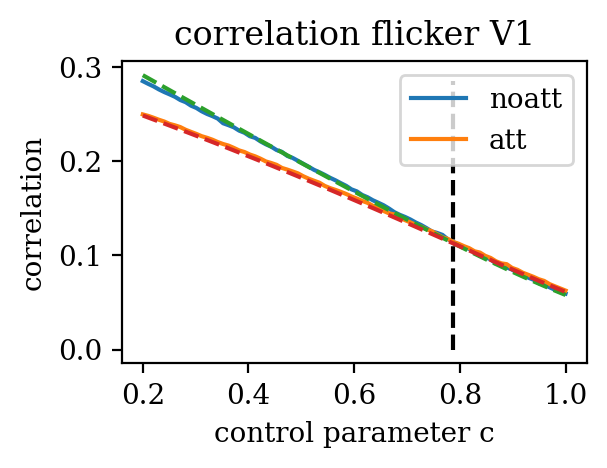

In [18]:
# Flicker to V1 correlations
ccfA4 = r['c_ccfAA'] 
ccfB4 = r['c_ccfBB'] 
title = 'correlation flicker V1'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200)
m = max(np.max(ccfA4[:,ri,0]),np.max(ccfB4[:,ri,0]))
plt.plot(c1s,ccfA4[:,ri,0],label='noatt')
plt.plot(c1s,ccfB4[:,ri,0],label='att' )
#thresholds,c1s_ana,acs,bcs = pickle.load(open('flicker_v1_corrs_mis_c1_thresholds_c01.pickle','rb'))
thresholds,c1s_ana,acs,bcs = pickle.load(open('data/flicker_v1_corrs_mis_c1_thresholds.pickle','rb'))
plt.plot(c1s_ana,acs[:,0],linestyle='dashed')
plt.plot(c1s_ana,bcs[:,0],linestyle='dashed')
plt.vlines([c1s[copt]],ymin=0,ymax=m,linestyle='dashed',color='k')
plt.legend()
plt.title(title)
plt.xlabel('control parameter c')
plt.ylabel('correlation')
# plt.savefig('img/'+title+'.png',dpi=200)
# plt.savefig('img/'+title+'.svg')


Text(0, 0.5, 'correlation')

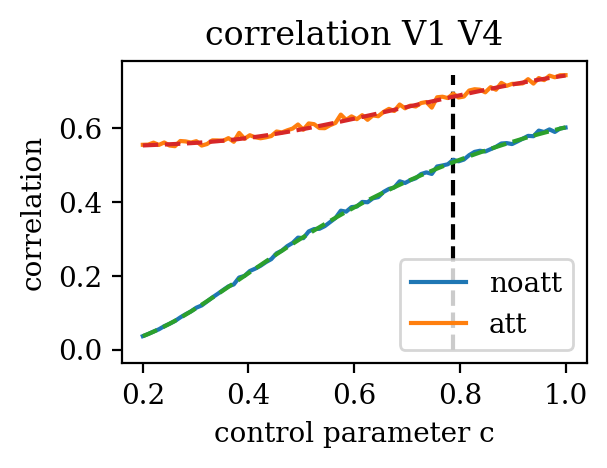

In [20]:
# V1 to V4
ccfA4 = r['c_ccAV4'] 
ccfB4 = r['c_ccBV4'] 
title = 'correlation V1 V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200)
m = max(np.max(ccfA4[:,ri,0]),np.max(ccfB4[:,ri,0]))
plt.plot(c1s,ccfA4[:,ri,0],label='noatt')
plt.plot(c1s,ccfB4[:,ri,0],label='att' )
thresholds,c1_anas,acs,bcs = pickle.load(open('data/v1_v4_corrs_mis_c1_thresholds.pickle','rb'))
plt.plot(c1_anas,acs[:,0],linestyle='dashed')
plt.plot(c1_anas,bcs[:,0],linestyle='dashed')
plt.vlines([c1s[copt]],ymin=0,ymax=m,linestyle='dashed',color='k')
plt.legend()
plt.title(title)
plt.xlabel('control parameter c')
plt.ylabel('correlation')
# plt.savefig('img/'+title+'.png',dpi=200)
# plt.savefig('img/'+title+'.svg')


Text(0, 0.5, 'correlation')

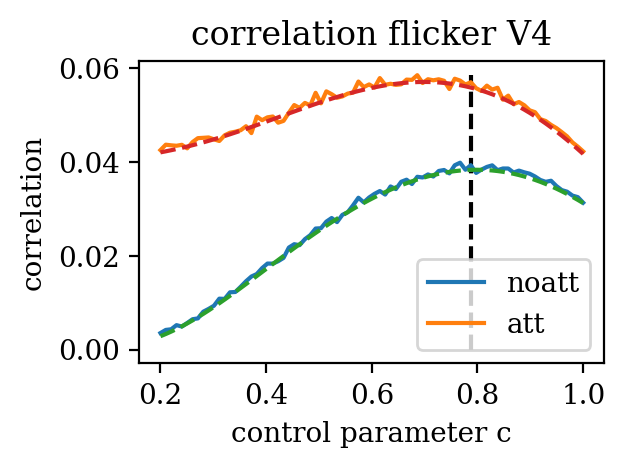

In [21]:
# flicker to V4
ccfA4 = r['c_ccfAV4']
ccfB4 = r['c_ccfBV4']
title = 'correlation flicker V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200)
m = max(np.max(ccfA4[:,ri,0]),np.max(ccfB4[:,ri,0]))
plt.plot(c1s,ccfA4[:,ri,0],label='noatt')
plt.plot(c1s,ccfB4[:,ri,0],label='att' )
thresholds,c1_anas,acs,bcs = pickle.load(open('data/flicker_v4_corrs_mis_c1_thresholds.pickle','rb'))
plt.plot(c1_anas,acs[:,5],linestyle='dashed') # hier 5 ohne c01 1 mit c01
plt.plot(c1_anas,bcs[:,5],linestyle='dashed') # hier 5 ohne c01 1 mit c01
plt.vlines([c1s[copt]],ymin=0,ymax=m,linestyle='dashed',color='k')
plt.legend()
plt.title(title)
plt.xlabel('control parameter c')
plt.ylabel('correlation')
# plt.savefig('img/'+title+'.png',dpi=200)
# plt.savefig('img/'+title+'.svg')

And now the bottom row with the ratio of spectral coherences. 
Again, start with flicker to V1

<ipython-input-22-3a13ea1c3024>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ca = plt.pcolormesh(c1s[c_start:],freqs,scdiff_norm[:,c_start:],vmin=-m,vmax=m,


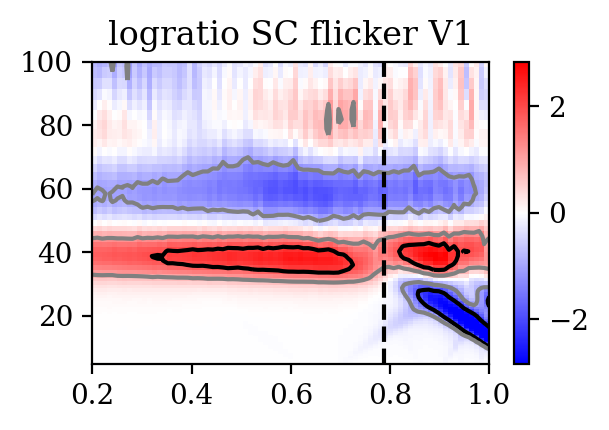

In [22]:
ccfA4 = r['scfAA']
ccfB4 = r['scfBB']
suptitle = 'logratio SC flicker V1'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=plot_figsize,dpi=200)
scdiff_norm = np.log2(ccfB4[:,ri,ar,:].T/ccfA4[:,ri,ar,:].T)
min_v = np.min(scdiff_norm)
max_v = np.max(scdiff_norm)
m = max(min_v,max_v)
ca = plt.pcolormesh(c1s[c_start:],freqs,scdiff_norm[:,c_start:],vmin=-m,vmax=m,
                    cmap="bwr")
plt.contour(c1s[c_start:],freqs,scdiff_norm[:,c_start:],levels=plot_levels,colors=plot_colors)
plt.colorbar(ca)
plt.title(suptitle)
plt.ylim(freqs[0],fmax)
if plot_vline:
    plt.vlines(c1s[copt],ymin=freqs[0],ymax=fmax,color='black',linestyle='dashed')
# plt.savefig('img/'+suptitle+'.png',dpi=200)
# plt.savefig('img/'+suptitle+'.svg')


<ipython-input-23-7815f27320c7>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ca = plt.pcolormesh(c1s[c_start:],freqs,scdiff_norm[:,c_start:],vmin=-m,vmax=m,


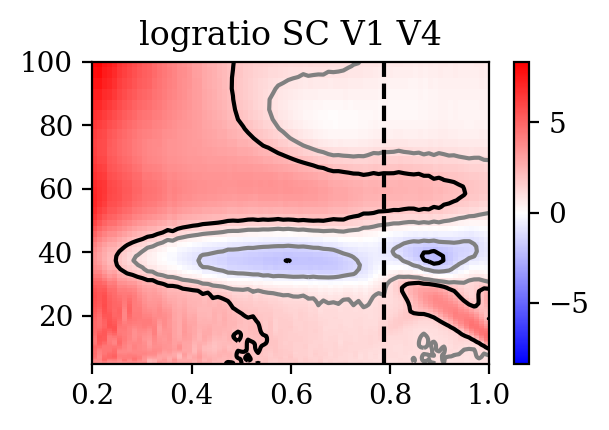

In [23]:
# V1 to V4
ccfA4 = r['sc4A']
ccfB4 = r['sc4B']
suptitle = 'logratio SC V1 V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=plot_figsize,dpi=200)
scdiff_norm = np.log2(ccfB4[:,ri,ar,:].T/ccfA4[:,ri,ar,:].T)
min_v = np.min(scdiff_norm)
max_v = np.max(scdiff_norm)
m = max(min_v,max_v)
ca = plt.pcolormesh(c1s[c_start:],freqs,scdiff_norm[:,c_start:],vmin=-m,vmax=m,
                    cmap="bwr")
plt.contour(c1s[c_start:],freqs,scdiff_norm[:,c_start:],levels=plot_levels,colors=plot_colors)
plt.colorbar(ca)
plt.title(suptitle)
plt.ylim(freqs[0],fmax)
if plot_vline:
    plt.vlines(c1s[copt],ymin=freqs[0],ymax=fmax,color='black',linestyle='dashed')
# plt.savefig('img/'+suptitle+'.png',dpi=200)
# plt.savefig('img/'+suptitle+'.svg')


<ipython-input-24-35d1be6efe93>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ca = plt.pcolormesh(c1s[c_start:],freqs,scdiff_norm[:,c_start:],vmin=-m,vmax=m,


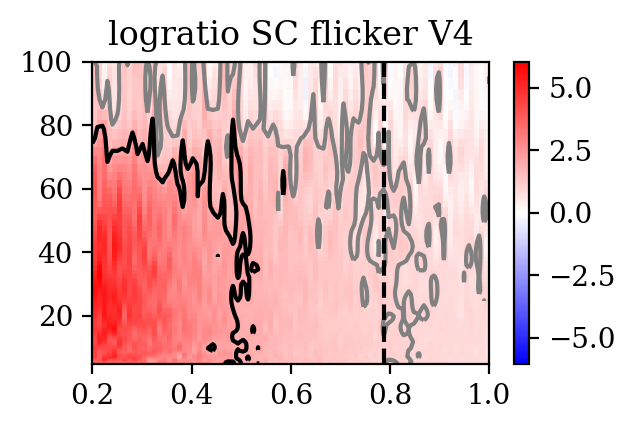

In [24]:
# and finally flicker to V4 
ccfA4 = r['sc4fA']
ccfB4 = r['sc4fB']
suptitle = 'logratio SC flicker V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=plot_figsize,dpi=200)
scdiff_norm = np.log2(ccfB4[:,ri,ar,:].T/ccfA4[:,ri,ar,:].T)
min_v = np.min(scdiff_norm)
max_v = np.max(scdiff_norm)
m = max(min_v,max_v)
ca = plt.pcolormesh(c1s[c_start:],freqs,scdiff_norm[:,c_start:],vmin=-m,vmax=m,
                    cmap="bwr")
plt.contour(c1s[c_start:],freqs,scdiff_norm[:,c_start:],levels=plot_levels,colors=plot_colors)
plt.colorbar(ca)
plt.title(suptitle)
plt.ylim(freqs[0],fmax)
if plot_vline:
    plt.vlines(c1s[copt],ymin=freqs[0],ymax=fmax,color='black',linestyle='dashed')
# plt.savefig('img/'+suptitle+'.png',dpi=200)
# plt.savefig('img/'+suptitle+'.svg')

## Reproduce figure 4 

The following code blocks plot the summed SC values over beta and print the value at copt, which is displayed on the 
bar plot in figure 4 a) 

copt att 0.4715506985099496
copt noatt 0.5009767368411534


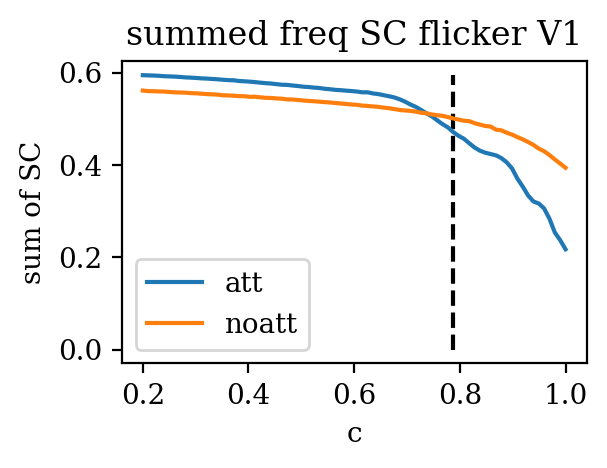

In [89]:
ccfA4 = r['scfAA']
ccfB4 = r['scfBB']
suptitle = 'summed freq SC flicker V1'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200);
plt.title(suptitle)
plt.plot(c1s,np.mean(ccfB4[:,0,0,:fmi],axis=-1),label='att');
plt.plot(c1s,np.mean(ccfA4[:,0,0,:fmi],axis=-1),label='noatt')
plt.legend()
m = max(np.max(np.mean(ccfB4[:,0,0,:fmi],axis=-1)),np.max(np.mean(ccfA4[:,0,0,:fmi],axis=-1)))
plt.vlines(c1s[copt],ymin=0,ymax=m,color='black',linestyle='dashed')
plt.xlabel('c')
plt.ylabel('sum of SC')
print('copt att',np.mean(ccfB4[copt,0,0,:fmi],axis=-1))
print('copt noatt',np.mean(ccfA4[copt,0,0,:fmi],axis=-1))
# plt.savefig('img/'+suptitle+'summed_freq.png',dpi=200)
# plt.savefig('img/'+suptitle+'summed_freq.svg')



copt att 0.37305338276748445
copt noatt 0.20277814428727692


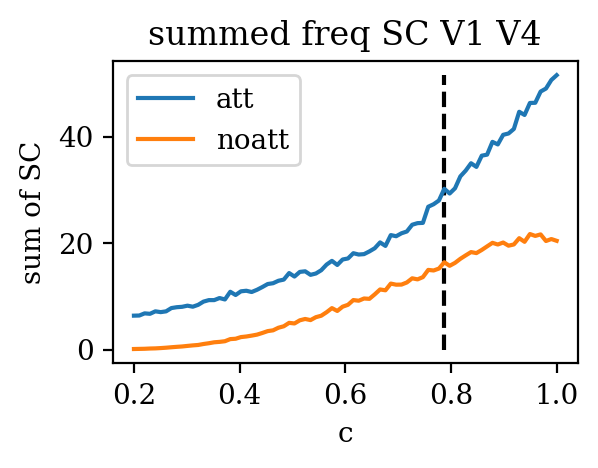

In [91]:
ccfA4 = r['sc4A']
ccfB4 = r['sc4B']
suptitle = 'summed freq SC V1 V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200);
plt.title(suptitle)
plt.plot(c1s,np.sum(ccfB4[:,0,0,:fmi],axis=-1),label='att');
plt.plot(c1s,np.sum(ccfA4[:,0,0,:fmi],axis=-1),label='noatt')
plt.legend()
m = max(np.max(np.sum(ccfB4[:,0,0,:fmi],axis=-1)),np.max(np.sum(ccfA4[:,0,0,:fmi],axis=-1)))
plt.vlines(c1s[copt],ymin=0,ymax=m,color='black',linestyle='dashed')
plt.xlabel('c')
plt.ylabel('sum of SC')
print('copt att',np.mean(ccfB4[copt,0,0,:fmi],axis=-1))
print('copt noatt',np.mean(ccfA4[copt,0,0,:fmi],axis=-1))



copt att 0.13846988966991045
copt noatt 0.06640922871709962


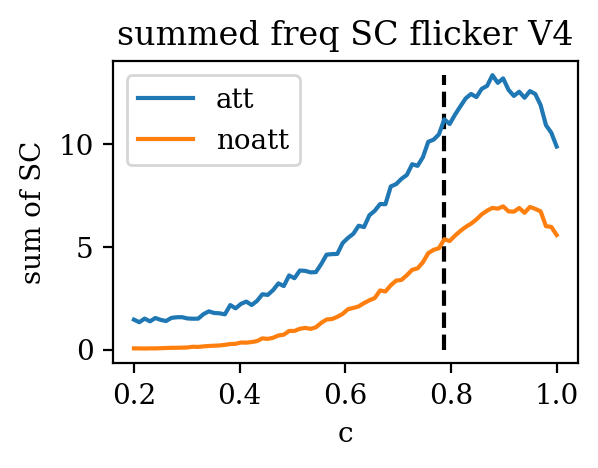

In [92]:
ccfA4 = r['sc4fA']
ccfB4 = r['sc4fB']
suptitle = 'summed freq SC flicker V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200);
plt.title(suptitle)
plt.plot(c1s,np.sum(ccfB4[:,0,0,:fmi],axis=-1),label='att');
plt.plot(c1s,np.sum(ccfA4[:,0,0,:fmi],axis=-1),label='noatt')
plt.legend()
m = max(np.max(np.sum(ccfB4[:,0,0,:fmi],axis=-1)),np.max(np.sum(ccfA4[:,0,0,:fmi],axis=-1)))
plt.vlines(c1s[copt],ymin=0,ymax=m,color='black',linestyle='dashed')
plt.xlabel('c')
plt.ylabel('sum of SC')
print('copt att',np.mean(ccfB4[copt,0,0,:fmi],axis=-1))
print('copt noatt',np.mean(ccfA4[copt,0,0,:fmi],axis=-1))
# plt.savefig('img/'+suptitle+'summed_freq.png',dpi=200)
# plt.savefig('img/'+suptitle+'summed_freq.svg')



Panel d) of figure 4: 

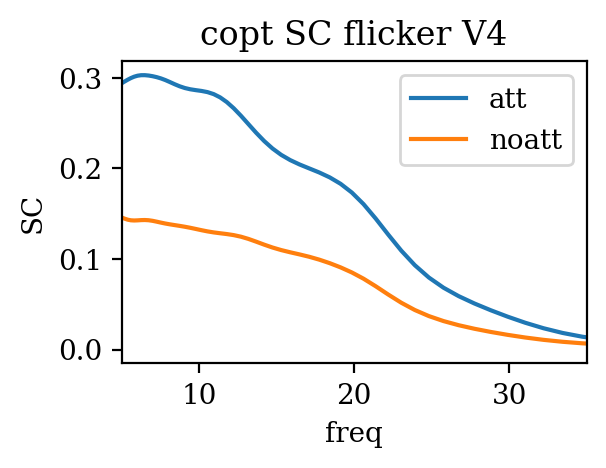

In [94]:
ccfA4 = r['sc4fA']
ccfB4 = r['sc4fB']
suptitle = 'copt SC flicker V4'
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
plt.figure(figsize=(3,2),dpi=200);
plt.title(suptitle)
plt.plot(freqs,ccfB4[copt,0,0],label='att');
plt.plot(freqs,ccfA4[copt,0,0],label='noatt')
plt.xlabel('freq')
plt.ylabel('SC')
plt.xlim([freqs[0],35])
plt.legend()
# plt.savefig('img/'+suptitle+'opt.png',dpi=200)
# plt.savefig('img/'+suptitle+'opt.svg')


For panel b) and c) of figure 4, the avalanche size distribution and phase coherence values obtained in the main 
simulation script are plotted. These values were not saved during the main simulation run, but instead obtained by 
locally executing the main script with the optimal beta value set (index 58). 
To avoid having to re-run this script, the needed phase coherences and avalanche distributions were extracted to 
data/avs_pc_copt.pickle. 
The following cells load this data and recreate the panels b) and c) of figure 4

computing detailed avs took 35.027796506881714 seconds


Text(0.5, 1.0, 'analytical av. dist.')

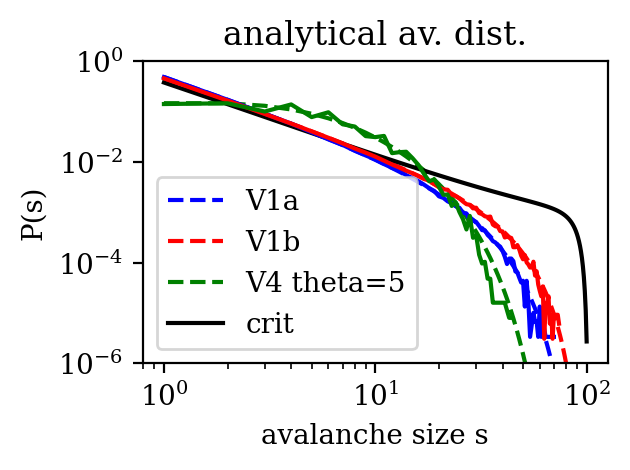

In [103]:
avs_pc = pickle.load(open('data/avs_pc_copt.pickle','rb'))
c1 = np.linspace(0.2,1,80)[58]
c3 = 0.4#'auto'
cup=0.3;
c_control = 0.095
n=100;

import time
st = time.time()
detailed_dist = detailed_avs_dist_3pop(c1,c3,cup,c_control,n)
print('computing detailed avs took '+str(time.time()-st)+' seconds')

s=5; # for n=1000 # war vorher threshold
V1a,V1b,V4 = avs_size_distributions_3pop(detailed_dist,s,V4ext=False,p = None)
plt.figure(figsize=(3,2),dpi=200)
plt.loglog(np.arange(n)+1,V1a,label='V1a',color='blue',linestyle='dashed')
plt.loglog(np.arange(n)+1,V1b,label='V1b',color='red',linestyle='dashed')
plt.loglog(np.arange(n)+1,V4,label='V4 theta='+str(s),color='green',linestyle='dashed')
plt.loglog(np.arange(n)+1,ehe_ana(0.9,100),label='crit',color='black')#,linestyle='dashed')

#plt.figure(figsize=(6,4),dpi=200)
avs_V1a = avs_pc['avs'][:,0]
u,c = np.unique(avs_V1a[avs_V1a>0],return_counts=True)
c = c / np.sum(c)
plt.loglog(u,c,color='blue')
avs_V1b = avs_pc['avs'][:,2]
u,c = np.unique(avs_V1b[avs_V1b>0],return_counts=True)
c = c / np.sum(c)
plt.loglog(u,c,color='red')
avs_V1b = avs_pc['avs'][:,4]
u,c = np.unique(avs_V1b[avs_V1b>0],return_counts=True)
c = c / np.sum(c)
plt.loglog(u,c,color='green')
plt.ylim([1e-6,1])
plt.legend()
plt.xlabel('avalanche size s')
plt.ylabel('P(s)')
plt.title('analytical av. dist.')

Text(0, 0.5, 'Phase coherence')

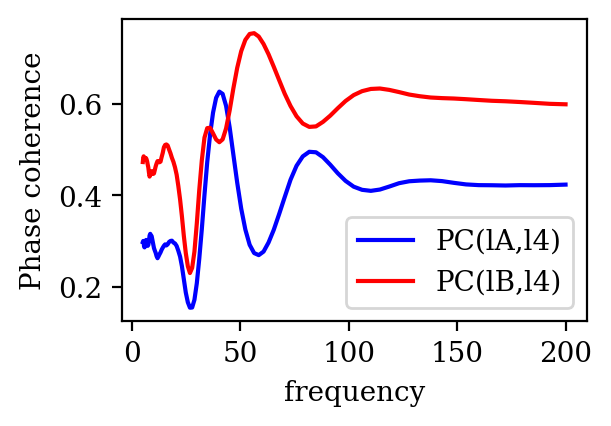

In [95]:
avs_pc = pickle.load(open('data/avs_pc_copt.pickle','rb'))
plt.figure(dpi=200,figsize=(3,2))
plt.plot(avs_pc['freqs'],avs_pc['pc_a4'],label='PC(lA,l4)',color='blue')
plt.plot(avs_pc['freqs'],avs_pc['pc_ba4'],label='PC(lB,l4)',color='red')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('Phase coherence')

## Reproduce effect of synchronicity gain figure 5

the numerical correlation results for thresholds 2 and 10 were obtained in exactly the same way as for the
threshold 5 described above. The collected results from all jobs are saved in the data subdirectory 

<ipython-input-82-c3885b9001d1>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)
<ipython-input-82-c3885b9001d1>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,3)
<ipython-input-82-c3885b9001d1>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

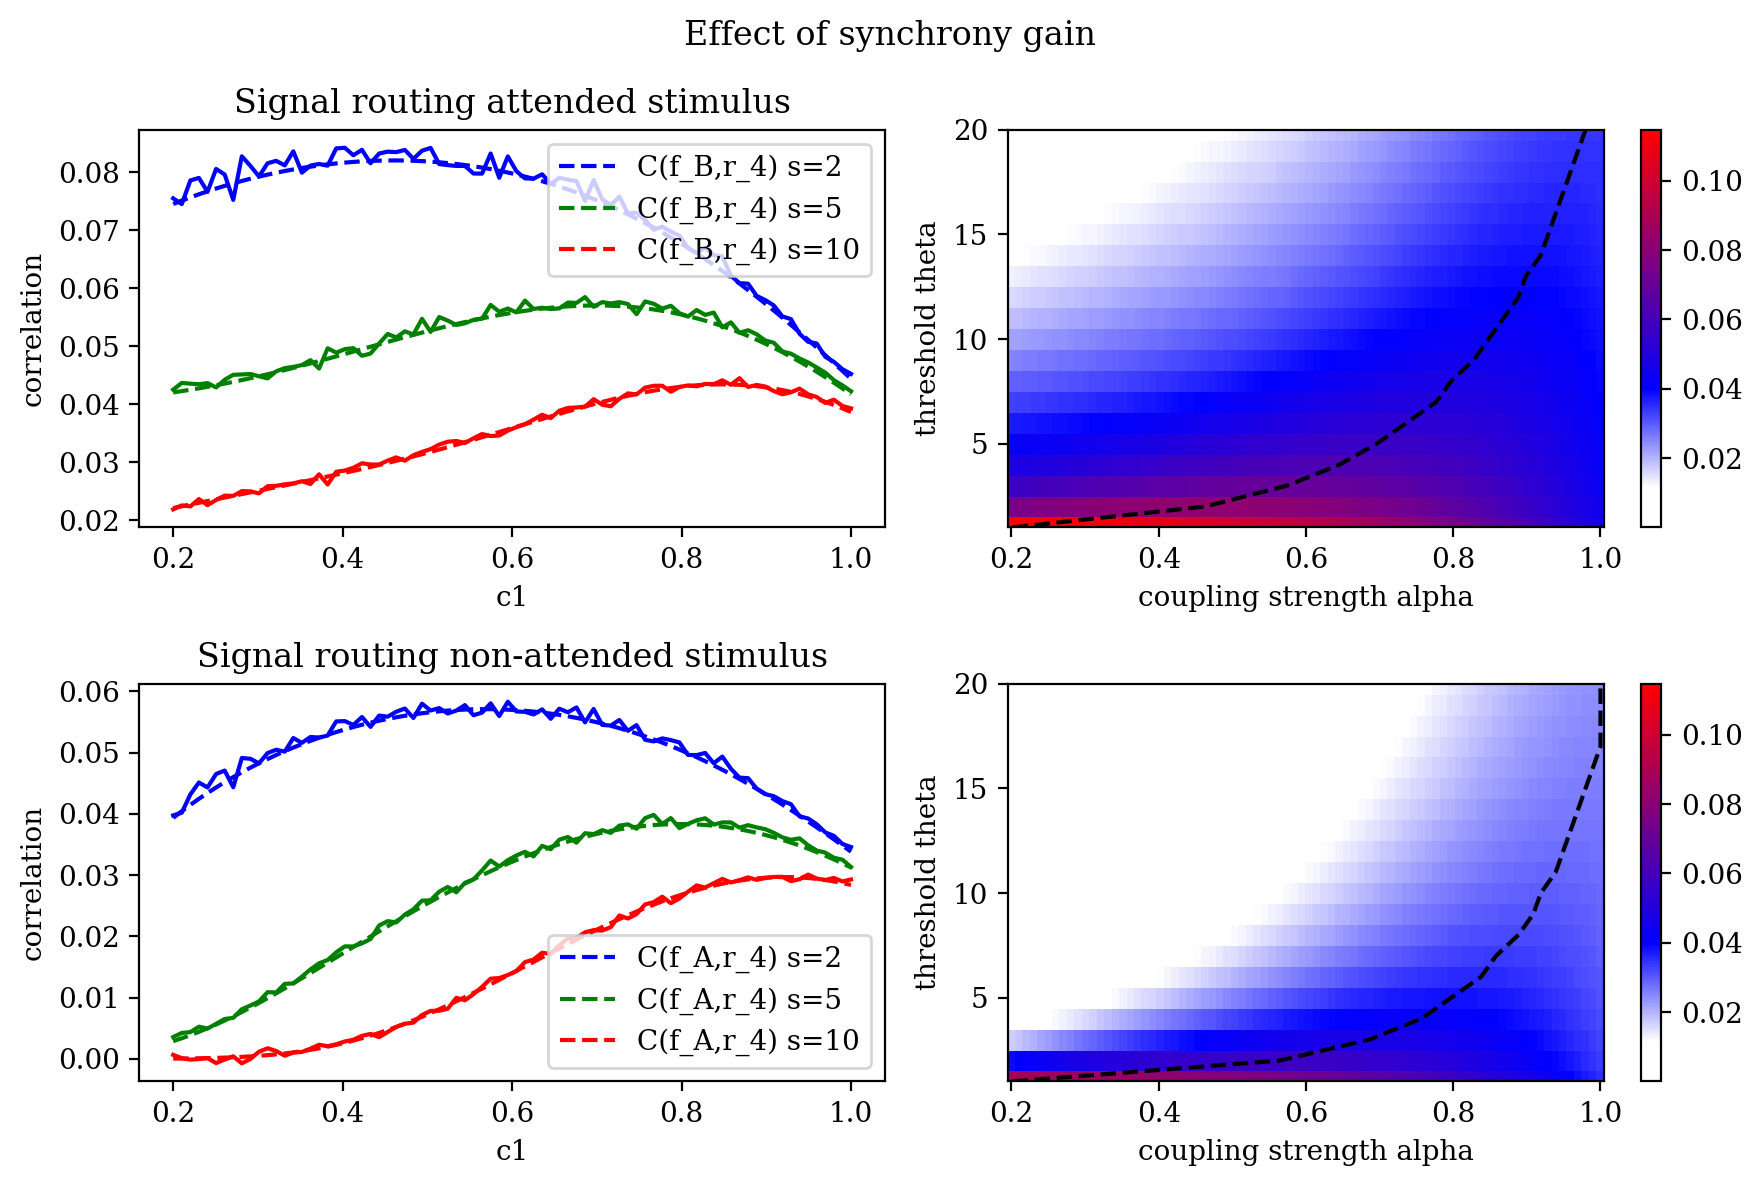

In [82]:
%matplotlib inline
thresholds,c1s,acs,bcs = pickle.load(open('data/flicker_v4_corrs_mis_c1_thresholds.pickle','rb'))
ri = 0
plt.figure(figsize=1.5*np.array((6,4)),dpi=200)
plt.suptitle('Effect of synchrony gain')
plt.subplot(2,2,3)
plt.title('Signal routing non-attended stimulus')
plt.plot(c1s,acs[:,2],color='blue',label='C(f_A,r_4) s=2',linestyle='dashed')
plt.plot(c1s,acs[:,5],color='green',label='C(f_A,r_4) s=5',linestyle='dashed')
plt.plot(c1s,acs[:,10],color='red',label='C(f_A,r_4) s=10',linestyle='dashed')
#plt.ylim([0,0.1])
plt.legend()
plt.xlabel('c1')
plt.ylabel('correlation')
plt.subplot(2,2,1)
plt.title('Signal routing attended stimulus')
plt.plot(c1s,bcs[:,2],color='blue',label='C(f_B,r_4) s=2',linestyle='dashed')
plt.plot(c1s,bcs[:,5],color='green',label='C(f_B,r_4) s=5',linestyle='dashed')
plt.plot(c1s,bcs[:,10],color='red',label='C(f_B,r_4) s=10',linestyle='dashed')
#plt.ylim([0,0.1])
plt.legend()
plt.xlabel('c1')
plt.ylabel('correlation')
for r,col in zip([np.load(open('data/sc_collected_ehe_flicker_sync_new_c3_thresh'+str(s)+'.npz','rb')) for s in [2,5,10]],
                 ['blue','green','red']):
    ccfA4 = r['c_ccfAV4']
    ccfB4 = r['c_ccfBV4']
    ccfA4 = np.nanmean(ccfA4,axis=3)
    ccfB4 = np.nanmean(ccfB4,axis=3)
    plt.subplot(2,2,1)
    plt.plot(c1s,ccfB4[:,ri,0],color=col)
    plt.subplot(2,2,3)
    plt.plot(c1s,ccfA4[:,ri,0],color=col)

mi = min(acs.min(),bcs.min())
ma = max(acs.max(),bcs.max())
#plt.figure(dpi=200)
plt.subplot(2,2,2)
#plt.title('signal routing attended stimulus')
plt.pcolormesh(np.linspace(0.2,1,80),thresholds,bcs.T,shading='nearest',linewidth=2,vmin=mi,vmax=ma,cmap=cmap_old)
plt.plot(np.linspace(0.2,1,80)[bcs.argmax(axis=0)],thresholds,'k--')
plt.colorbar()
plt.xlabel('coupling strength alpha')
plt.ylabel('threshold theta')
plt.ylim([1,20])
plt.subplot(2,2,4)

#plt.title('correlation non-attended stimulus')
plt.pcolormesh(np.linspace(0.2,1,80),thresholds,acs.T,shading='nearest',linewidth=2,vmin=mi,vmax=ma,cmap=cmap_old)
plt.plot(np.linspace(0.2,1,80)[acs.argmax(axis=0)],thresholds,'k--')
plt.colorbar()
plt.xlabel('coupling strength alpha')
plt.ylabel('threshold theta')
plt.ylim([1,20])
plt.tight_layout()

# Recreate figure 6

The simulation script containing the described parameter choice of the integrate and fire neuron can be found at 
scripts/ehe_flicker_sync_better_params_only_cc.py.
After this script has been run on the cluster for all parameter values, the relevant data was summarized using scripts/sim_iaf_collect_onlycc.py resulting in the file data/sc_collected_ehe_flicker_sync_better_params_only_cc_tau0.npz which is loaded by the next cell. 
The parameters for the iaf neuron are set in the script starting at line 232, the rest of the simulation is the same as in the main script. 

<ipython-input-86-ba2ec84d300b>:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolormesh(c1s,freqs[:fmi],np.log2(ccfB4/ccfA4)[:,ri,0,:fmi].T,cmap='bwr',vmin=-1.5,vmax=1.5)


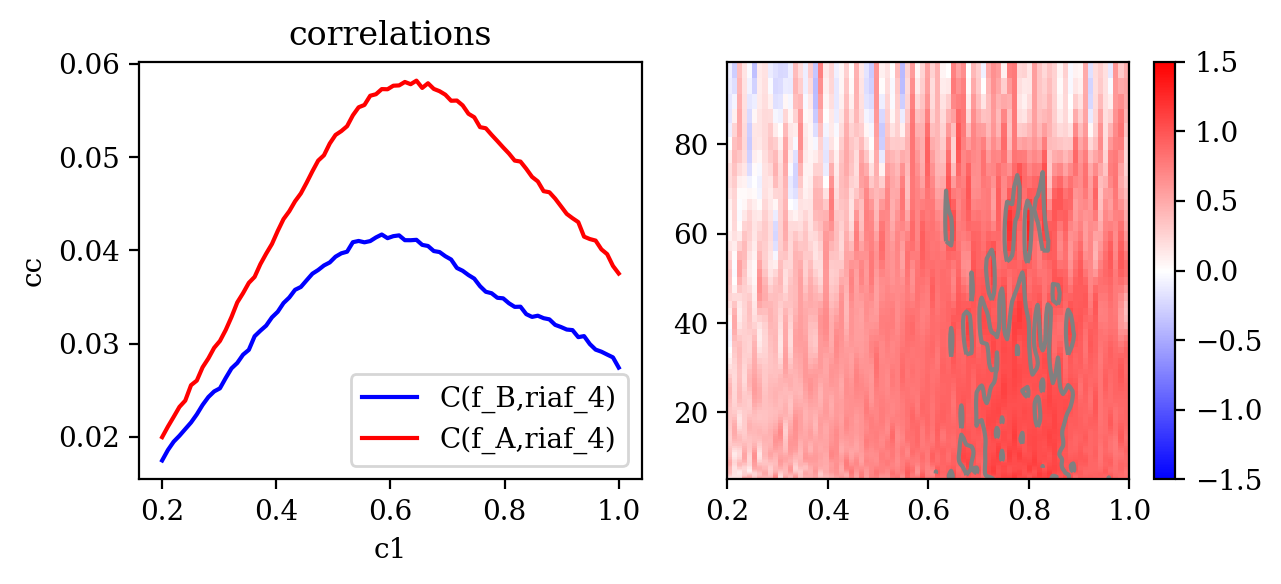

In [86]:
c1s = np.linspace(0.2,1,80)
radvs = np.array([12])
methods = ['int','ext']

#r = np.load(open('sc_collected_ehe_flicker_sync_iaf_better_params_more_data.npz','rb'))
r = np.load(open('data/sc_collected_ehe_flicker_sync_better_params_only_cc_tau0.npz','rb'))
ccfA4 = r['ccfA4_leak']
ccfB4 = r['ccfB4_leak']

ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)


ri = 0

plt.figure(dpi=200,figsize = [6.55, 3.02])
plt.subplot(1,2,1)

plt.plot(c1s,ccfA4[:,ri,0],label=f'C(f_B,riaf_4)',color='blue')
plt.plot(c1s,ccfB4[:,ri,0],label=f'C(f_A,riaf_4)',color='red' )
#plt.vlines([c1s[np.argmax(ccfB4[:,ri,0])]],ymin=0,ymax=0.06,linestyle='dashed',color='k')
plt.legend()
plt.title('correlations')
plt.ylabel('cc')
plt.xlabel('c1')
plt.legend()

ccfA4 = r['scfA4_leak_tau0']
ccfB4 = r['scfB4_leak_tau0']
ccfA4 = np.nanmean(ccfA4,axis=3)
ccfB4 = np.nanmean(ccfB4,axis=3)
ri = 0

freqs= np.logspace(np.log10(5),np.log10(200),100)
fmax = 100
fmi = np.searchsorted(freqs,fmax)

#plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
# plt.plot(c1s,ccfA4[:,ri,0,:fmi].mean(axis=1),label=f'SC(f_B,riaf_4)',color='blue')
# plt.plot(c1s,ccfB4[:,ri,0,:fmi].mean(axis=1),label=f'SC(f_A,riaf_4)',color='red' )
# #plt.vlines([c1s[np.argmax(ccfB4[:,ri,0])]],ymin=0,ymax=25,linestyle='dashed',color='k')
# plt.title('spectral coherences')
# plt.legend()


plot_levels=[np.log2(0.25),np.log2(0.5),np.log2(2),np.log2(4)]
plot_colors=['black','gray','gray','black']

#plt.figure(dpi=200)
c = plt.pcolormesh(c1s,freqs[:fmi],np.log2(ccfB4/ccfA4)[:,ri,0,:fmi].T,cmap='bwr',vmin=-1.5,vmax=1.5)
plt.contour(c1s,freqs[:fmi],np.log2(ccfB4/ccfA4)[:,ri,0,:fmi].T,levels=plot_levels,colors=plot_colors)
plt.colorbar(c)
plt.tight_layout()

## Reproduce PID figure 7

In [72]:
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    import matplotlib.pyplot as plt


    # plt.rcParams['font.size'] = 16
    # plt.rcParams['font.family'] = 'Calibri'
    # plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    color_A = '#C00000'
    color_B = '#8080CC'
    color_C = '#000000'

    def WBR(n_cols):
        x = np.arange(0,n_cols)/(n_cols-1);
        x_grid = np.array([0, 0.1, 0.35, 1.0])
        c_grid = np.array([[1, 1, 1],[1,1, 1],[0, 0, 1],[1, 0, 0]]);
        c = np.zeros([n_cols, 3]);
        for rgb in range(3):
            c[:, rgb] = np.interp(x,x_grid, c_grid[:, rgb]);
        return c


    cmap_old = ListedColormap(WBR(256))

<ipython-input-78-adda7007f861>:48: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


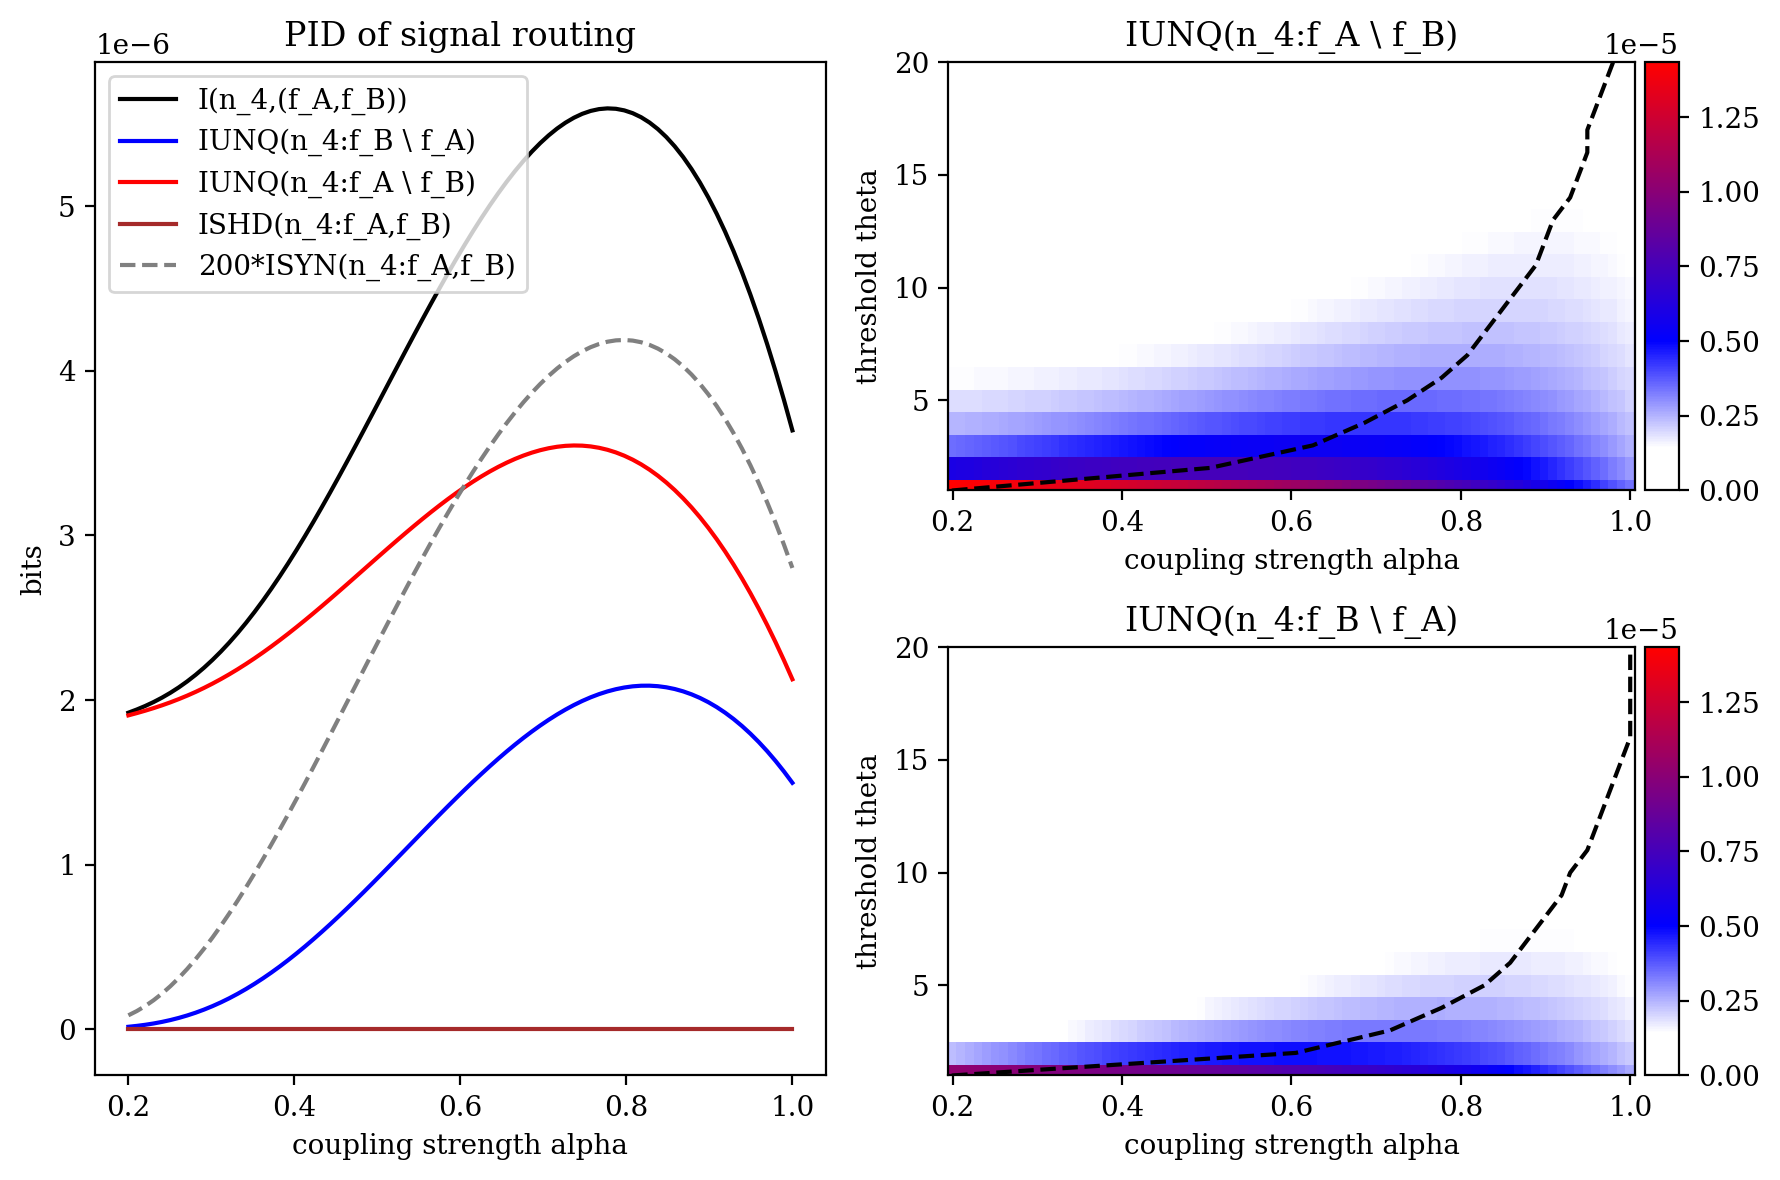

In [78]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
thresholds,c1s,acs,bcs,cis = pickle.load(open('data/fv4misneu.pickle','rb'))
cis = np.array(cis)
fig = plt.figure(figsize=3*np.array([3,2]),constrained_layout=True,dpi=200)
gs = GridSpec(2,2)
ax1 = fig.add_subplot(gs[:,0])
sidx=5
ax1.plot(np.linspace(0.2,1,80),(acs[:,sidx]+bcs[:,sidx]+cis[:,sidx]),color='black',label='I(n_4,(f_A,f_B))')
ax1.plot(np.linspace(0.2,1,80),(acs[:,sidx]),color='blue',label='IUNQ(n_4:f_B \ f_A)')
ax1.plot(np.linspace(0.2,1,80),(bcs[:,sidx]),color='red',label='IUNQ(n_4:f_A \ f_B)')
ax1.plot(np.linspace(0.2,1,80),[0]*80,color='brown',label='ISHD(n_4:f_A,f_B)')
ax1.plot(np.linspace(0.2,1,80),(200*cis[:,sidx]),color='gray',label='200*ISYN(n_4:f_A,f_B)',linestyle='dashed')
ax1.set_xlabel('coupling strength alpha')
ax1.set_ylabel('bits')
ax1.set_title('PID of signal routing')
ax1.legend(loc='best')

# ax2.plot(np.linspace(0.2,1,80)[bcs.argmax(axis=0)],thresholds,)
# ax2.plot(np.linspace(0.2,1,80)[acs.argmax(axis=0)],thresholds,)
# ax2 = plt.gca().twinx()
# ax2.plot(np.linspace(0.2,1,80),bcs
#          .max(axis=0))
# ax2.plot(np.linspace(0.2,1,80),acs.max(axis=0))
ax2 = fig.add_subplot(gs[0,1])
#thresholds,c1s,acs,bcs = pickle.load(open('flicker_v4_mis_c1_thresholds.pickle','rb'))
mi = min(acs.min(),bcs.min())
ma = max(acs.max(),bcs.max())
im = ax2.pcolormesh(np.linspace(0.2,1,80),thresholds,bcs.T,shading='nearest',linewidth=2,vmin=mi,vmax=ma,cmap=cmap_old)
ax2.plot(np.linspace(0.2,1,80)[bcs.argmax(axis=0)],thresholds,'k--')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax2.set_xlabel('coupling strength alpha')
ax2.set_ylabel('threshold theta')
ax2.set_ylim([1,20])
ax2.set_title('IUNQ(n_4:f_A \ f_B)')
ax3 = fig.add_subplot(gs[1,1])
im = ax3.pcolormesh(np.linspace(0.2,1,80),thresholds,acs.T,shading='nearest',linewidth=2,vmin=mi,vmax=ma,cmap=cmap_old)
ax3.plot(np.linspace(0.2,1,80)[acs.argmax(axis=0)],thresholds,'k--')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax3.set_xlabel('coupling strength alpha')
ax3.set_ylabel('threshold theta')
ax3.set_ylim([1,20])
ax3.set_title('IUNQ(n_4:f_B \ f_A)')
plt.tight_layout()
# plt.savefig('img/PID_fig.png',dpi=200)
# plt.savefig('img/PID_fig.png',svg=200)
